In [17]:
import mygene
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# MyGene API를 통해 유전자 정보 가져오기 함수
def process_gene_file(file_path, color, label):
    # 유전자 리스트 준비
    gene_list = pd.read_csv(file_path)
    gene_list = gene_list['Gene Symbol'].tolist()

    # MyGene API 호출
    mg = mygene.MyGeneInfo()
    query = mg.querymany(gene_list, scopes='symbol', fields='chrom,genomic_pos', species='human')
    df = pd.DataFrame(query)

    # 유효한 'genomic_pos' 필드만 남김
    df = df.dropna(subset=['genomic_pos'])

    # 'notfound' 컬럼 제거
    if 'notfound' in df.columns:
        df = df.drop(columns=['notfound'])

    # 'genomic_pos' 필드에서 필요한 값 추출
    def filter_and_flatten(genomic_loc):
        if isinstance(genomic_loc, list):
            filtered = [d for d in genomic_loc if not d.get('chr', '').startswith('H')]
            return filtered[0] if filtered else None
        elif isinstance(genomic_loc, dict):
            return genomic_loc
        return None

    df['genomic_pos'] = df['genomic_pos'].apply(filter_and_flatten)
    df = df.dropna(subset=['genomic_pos'])

    df['chrom'] = df['genomic_pos'].apply(lambda x: x.get('chr', None))
    df['start'] = df['genomic_pos'].apply(lambda x: x.get('start', None))

    # 색상 및 레이블 정보 추가
    df['color'] = color
    df['label'] = label

    return df

# 두 개의 CSV 파일 처리
df1 = process_gene_file("./extracted_genesets/mdel_pgain.csv", color="red", label="mdel_pgain")
df2 = process_gene_file("/home/jsw/Downloads/mart_export.txt", color="blue", label="Chr19")


21 input query terms found dup hits:	[('APOC1P1', 2), ('APOC4-APOC2', 2), ('BIRC8', 2), ('CEACAM22P', 2), ('CYP2G1P', 2), ('FKBP1AP1', 2)
159 input query terms found no hit:	['ACPT', 'ADCK4', 'ATP5SL', 'C19orf40', 'C19orf46', 'C19orf48', 'C19orf51', 'C19orf54', 'C19orf55', 
255 input query terms found dup hits:	[('WASH5P', 2), ('WBP1LP11', 2), ('LINC01002', 2), ('SEPTIN14P19', 2), ('CICP19', 2), ('MADCAM1-AS1'


In [18]:

# 데이터 병합
combined_df = pd.concat([df1, df2], ignore_index=True)

# '19'와 '19_2', '19_1'로 x축 변경
combined_df['chrom'] = combined_df.apply(
    lambda row: '19' if row['label'] == 'mdel_pgain' and row['chrom'] == '19' else
                '19_2' if row['label'] == 'Chr19' and row['chrom'] == '19' else None,
    axis=1
)


In [21]:
df1

,query,_id,_score,genomic_pos,chrom,start,color,label
0,A1BG,1,19.416883,"{'chr': '19', 'end': 58353492, 'ensemblgene': ...",19,58345178,red,mdel_pgain
1,A1BG-AS1,503538,27.130838,"{'chr': '19', 'end': 58355455, 'ensemblgene': ...",19,58347718,red,mdel_pgain
3,ACTN4,81,17.960705,"{'chr': '19', 'end': 38731589, 'ensemblgene': ...",19,38647649,red,mdel_pgain
5,AKT1S1,84335,18.046598,"{'chr': '19', 'end': 49878459, 'ensemblgene': ...",19,49869033,red,mdel_pgain
6,AKT2,208,17.884615,"{'chr': '19', 'end': 40285536, 'ensemblgene': ...",19,40230317,red,mdel_pgain
...,...,...,...,...,...,...,...,...
983,ZSCAN18,65982,20.029404,"{'chr': '19', 'end': 58118427, 'ensemblgene': ...",19,58083838,red,mdel_pgain
984,ZSCAN22,342945,19.688830,"{'chr': '19', 'end': 58342332, 'ensemblgene': ...",19,58326994,red,mdel_pgain
985,ZSCAN4,201516,20.208664,"{'chr': '19', 'end': 57679152, 'ensemblgene': ...",19,57668935,red,mdel_pgain
986,ZSCAN5A,79149,24.269800,"{'chr': '19', 'end': 56368383, 'ensemblgene': ...",19,56219670,red,mdel_pgain


In [23]:

# Chr19에 있지만 mdel_pgain에는 없는 데이터 선택
chr19_genes = df2[df2['chrom'] == '19']['query']
mdel_pgain_genes = df1[df1['chrom'] == '19']['query']
unique_to_chr19 = chr19_genes[~chr19_genes.isin(mdel_pgain_genes)]

/tmp/ipykernel_44456/2278721199.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_unique['chrom'] = '19_1'


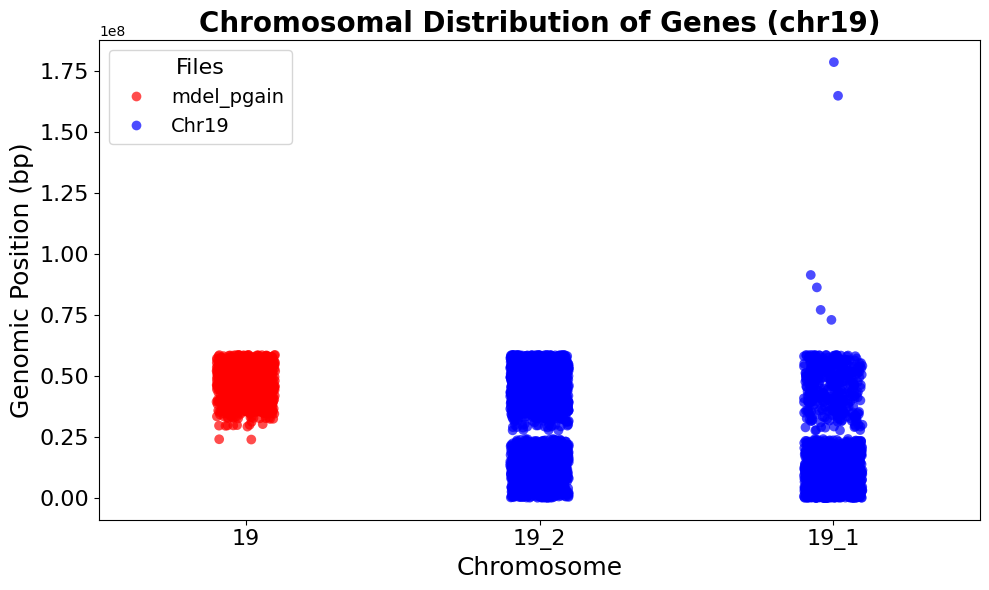

In [24]:


# '19_1'로 할당
df_unique = df2[df2['query'].isin(unique_to_chr19)]
df_unique['chrom'] = '19_1'

# 병합하여 최종 데이터프레임 생성
filtered_df = pd.concat([combined_df, df_unique], ignore_index=True)
filtered_df = filtered_df[filtered_df['chrom'].isin(['19', '19_1', '19_2'])]

# 시각화
plt.figure(figsize=(10, 6))
sns.stripplot(
    data=filtered_df,
    x='chrom', y='start', hue='label',
    jitter=True, size=7, alpha=0.7,
    palette={'mdel_pgain': 'red', 'Chr19': 'blue'}
)

# x축 및 y축 설정
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

# 그래프 제목과 축 이름 설정
plt.title('Chromosomal Distribution of Genes (chr19)', fontsize=20, fontweight='bold')
plt.xlabel('Chromosome', fontsize=18)
plt.ylabel('Genomic Position (bp)', fontsize=18)

# 범례 추가
plt.legend(title='Files', fontsize=14, title_fontsize=16)

plt.tight_layout()
plt.show()
